In [5]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.dpi'] = 400
import numpy as np

def update_panel_label(df):
    panel = []
    for i in df["Sera pool"]:
        if "BTI_BA.1" in i:
            panel.append("BA.1 BTI")
        elif "BTI_BA.4/5" in i:
            panel.append("BA.4/5 BTI")
        elif "BTI_BA.2.12.1" in i:
            panel.append("BA.2.12.1 BTI")
        elif "BTI_Delta" in i:
            panel.append("Delta BTI")
        elif "Conv_WT" in i:
            panel.append("WT Conv")
        elif "Conv_Delta" in i:
            panel.append("Delta Conv")
        elif "Boost" in i:
            if "Bi" in i:
                panel.append("Bi-valent Boost")
            else:
                panel.append("Boost")
        elif "Vac" in i:
            panel.append("Vaccine")
        else:
            panel.append("else")
    return(panel)

In [11]:
### NEUTRALIZATION DATA ###
neut_df = pd.read_excel('../Data/Supp_TableS7_Neutralization_Data.xlsx', sheet_name='ID50 titers (Pool)')

neut_df = neut_df.melt('Sera pool',var_name = "Name", value_name = "ID50")
neut_df = neut_df.replace({"<20" : 10})
neut_df['ID50'] = neut_df['ID50'].astype(float)
neut_df = neut_df.dropna()
neut_df['panel'] = update_panel_label(neut_df)
neut_df.head()

,Sera pool,Name,ID50,panel
0,Conv_Delta,B.1,17278.0,Delta Conv
1,Conv_WT-1,B.1,9294.0,WT Conv
2,Conv_WT-2,B.1,1788.0,WT Conv
3,Conv_WT-3,B.1,236.0,WT Conv
4,Vac_Mod-1,B.1,1691.0,Vaccine


In [12]:
boost_df = neut_df[neut_df["panel"]== "Bi-valent Boost"].copy()
boost_df.head()

,Sera pool,Name,ID50,panel
14,Bi-valent Boost,B.1,21373.0,Bi-valent Boost
36,Bi-valent Boost,Alpha,15782.0,Bi-valent Boost
58,Bi-valent Boost,Beta,4884.0,Bi-valent Boost
80,Bi-valent Boost,Delta,5984.0,Bi-valent Boost
102,Bi-valent Boost,Gamma,8960.0,Bi-valent Boost


In [17]:
pre_voc  = ["BA.2.75", "BQ.1", "BQ.1.1", "XBB"]
post_voc = ["XBB.1", "XBB.1.5", "CH.1.1"]


voc = pre_voc + post_voc
boost_df = pd.concat([boost_df[boost_df.Name.isin(voc)],
                     boost_df[boost_df.Name.str.contains("BA.2.75-|XBB-")]])
boost_df.head()

,Sera pool,Name,ID50,panel
212,Bi-valent Boost,BA.2.75,3097.0,Bi-valent Boost
234,Bi-valent Boost,BQ.1,2609.0,Bi-valent Boost
256,Bi-valent Boost,BQ.1.1,3149.0,Bi-valent Boost
278,Bi-valent Boost,XBB,653.0,Bi-valent Boost
300,Bi-valent Boost,XBB.1,538.0,Bi-valent Boost


In [18]:
label = []
for name in boost_df['Name']:
    if name in pre_voc:
        label.append('Pre')
    elif name in post_voc:
        label.append('Post')
    else:
        label.append('Designed')

boost_df['const/voc'] = label
order = ["Pre","Designed","Post"]

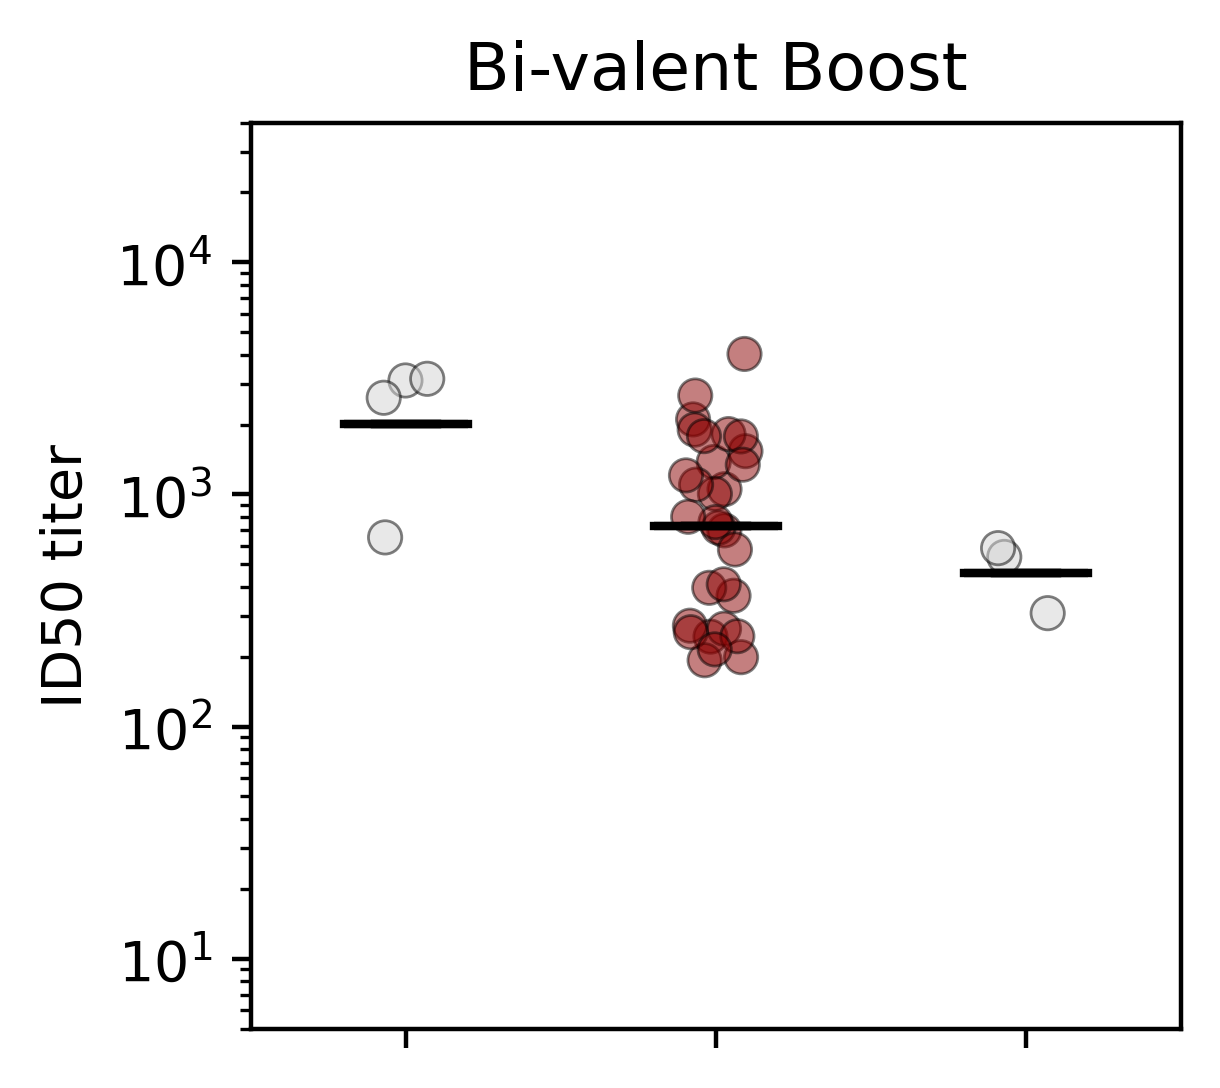

In [32]:
fig, axes = plt.subplots(1,1, sharey = False, sharex = True, figsize = (3,3))


## subplot C## 
sns.stripplot(data= boost_df, x= "const/voc", y = "ID50", hue="const/voc",
              palette=["lightgrey","lightgrey", "darkred"], 
              linewidth = 0.5,size = 6, edgecolor = 'k', alpha = 0.5, 
              order =order, ax=axes)

df_agg = boost_df.groupby(["const/voc"]).agg({"ID50": stats.gmean}).reset_index()
sns.boxplot(data = df_agg, x=df_agg["const/voc"], y=df_agg["ID50"], color = 'k',width=0.4,
            ax = axes, medianprops = {"color":'k'}, zorder= 10, order =order).set(yscale = 'log')


axes.set_ylabel("ID50 titer")
axes.set_yscale("log")

axes.set_xlabel("")
axes.set_title("Bi-valent Boost")

axes.set_xticks([0,1,2]) 
axes.set_xticklabels([])

axes.legend([],[], frameon=False)
axes.set_ylim(5, 4e4)

plt.xlim(-0.5, 2.5)
plt.savefig('../Figures/Fig4A_bi-boost_pre_post.svg', format='svg', layout = "tight")

In [26]:
df = boost_df.groupby(["panel", "const/voc"]).agg({"ID50": stats.gmean}).reset_index()
df

,panel,const/voc,ID50
0,Bi-valent Boost,Designed,734.341652
1,Bi-valent Boost,Post,459.893246
2,Bi-valent Boost,Pre,2018.948689


In [28]:
df[df['const/voc'] == 'Pre']['ID50'].values / df[df['const/voc'] == 'Post']['ID50'].values

array([4.39003771])

In [29]:
df[df['const/voc'] == 'Pre']['ID50'].values / df[df['const/voc'] == 'Designed']['ID50'].values

array([2.74933157])

In [30]:
c1 = 'Pre'
c2 = 'Designed'


x = boost_df[boost_df["const/voc"] == c1]["ID50"]
y = boost_df[boost_df["const/voc"] == c2]["ID50"]
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=22.0, pvalue=0.022510440501269328)

In [31]:
c1 = 'Pre'
c2 = 'Post'


x = boost_df[boost_df["const/voc"] == c1]["ID50"]
y = boost_df[boost_df["const/voc"] == c2]["ID50"]
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=0.0, pvalue=0.02591496360895484)